In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import spotipy
import spotipy.util as util
import re

from spotipy.oauth2 import SpotifyClientCredentials
from torch.utils import data
from torch.autograd import Variable


In [56]:
class CustomDataset(data.Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)

In [57]:
dataset = pd.read_csv(r'net2input.csv')
dataset_training = dataset.truncate(after=48000).reset_index(drop=True)
training_outputs = dataset_training['move_class'].to_numpy()
training_inputs = dataset_training.drop(columns=['move_class']).to_numpy()

training_data = CustomDataset(torch.LongTensor(training_inputs), torch.LongTensor(training_outputs))

dataset_testing = dataset.truncate(before=48001).reset_index(drop=True)
testing_outputs = dataset_testing['move_class'].to_numpy()
testing_inputs = dataset_testing.drop(columns=['move_class']).to_numpy()

testing_data = CustomDataset(torch.LongTensor(testing_inputs), torch.LongTensor(testing_outputs))


train_loader = torch.utils.data.DataLoader(dataset=training_data, batch_size = 1000, shuffle = True)
testing_loader = torch.utils.data.DataLoader(dataset=testing_data, batch_size = 1000, shuffle = True)

input_size = 8
output_size = dataset["move_class"].nunique()
hidden_size = 10


In [58]:
dataset

,index,start_time,duration,section,tempo,danceability,energy,valence,move_class
0,0,8.64248,0.53227,0,113.255,0.935,0.526,0.854,0
1,1,9.17475,0.53417,0,113.255,0.935,0.526,0.854,0
2,2,9.70893,0.53276,0,113.255,0.935,0.526,0.854,0
3,3,10.24169,0.53135,0,113.255,0.935,0.526,0.854,0
4,4,10.77303,0.52898,0,113.255,0.935,0.526,0.854,0
...,...,...,...,...,...,...,...,...,...
60894,485,206.29409,0.41231,7,144.041,0.687,0.514,0.494,3
60895,486,206.70641,0.41176,7,144.041,0.687,0.514,0.494,3
60896,487,207.11817,0.41164,7,144.041,0.687,0.514,0.494,3
60897,488,207.52981,0.41433,7,144.041,0.687,0.514,0.494,3


In [59]:
class Neural_Network(nn.Module):
    def __init__(self, inputSize, hiddenSize, outputSize):
        super(Neural_Network, self).__init__()
        self.fc1 = nn.Linear(inputSize, hiddenSize)
        self.relu = nn.Sigmoid()
        self.fc2 = nn.Linear(hiddenSize, outputSize)
        
    def forward(self, X):
        out = self.fc1(X)
        out = self.relu(out)
        out = self.fc2(out)
        return out


In [60]:
NN = Neural_Network(input_size, hidden_size, output_size)

# loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
learning_rate = 0.001
optimizer = torch.optim.SGD(NN.parameters(), lr=learning_rate, nesterov=True, momentum=0.9, dampening=0)

In [61]:
num_epochs = 100

train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []

NN = NN.float()
for epoch in range(num_epochs):
    
    train_correct = 0
    train_total = 0
    
    for i, batch in enumerate(train_loader):
        
        items = Variable(batch[0])
        classes = Variable(batch[1])
        
        NN.train()
        
        optimizer.zero_grad()
        outputs = NN(items.float())
        loss = criterion(outputs, classes)
        loss.backward()
        optimizer.step()
        
        train_total += classes.size(0)
        _, predicted = torch.max(outputs.data, 1)
        train_correct += (predicted == classes.data).sum()
        
        print("Epoch %d/%d, Iteration %d/%d"
                 %(epoch+1, num_epochs, i+1, len(dataset_training)//1000))
        print(loss)
        
    NN.eval()
        
    train_loss.append(loss.data)
        
    train_accuracy.append((100 * train_correct / train_total))
        
    test_items = torch.FloatTensor(testing_inputs)
    test_classes = torch.LongTensor(testing_outputs)
    outputs = NN(Variable(test_items))
    loss = criterion(outputs, Variable(test_classes))
    test_loss.append(loss.data)
    
    _, predicted = torch.max(outputs.data, 1)
    total = test_classes.size(0)
    correct = (predicted == test_classes).sum()
    test_accuracy.append((100 * correct / total))


Epoch 1/100, Iteration 1/48
tensor(2.8740, grad_fn=<NllLossBackward>)
Epoch 1/100, Iteration 2/48
tensor(2.8815, grad_fn=<NllLossBackward>)
Epoch 1/100, Iteration 3/48
tensor(2.8749, grad_fn=<NllLossBackward>)
Epoch 1/100, Iteration 4/48
tensor(2.8149, grad_fn=<NllLossBackward>)
Epoch 1/100, Iteration 5/48
tensor(2.8584, grad_fn=<NllLossBackward>)
Epoch 1/100, Iteration 6/48
tensor(2.8270, grad_fn=<NllLossBackward>)
Epoch 1/100, Iteration 7/48
tensor(2.8333, grad_fn=<NllLossBackward>)
Epoch 1/100, Iteration 8/48
tensor(2.8189, grad_fn=<NllLossBackward>)
Epoch 1/100, Iteration 9/48
tensor(2.8222, grad_fn=<NllLossBackward>)
Epoch 1/100, Iteration 10/48
tensor(2.8429, grad_fn=<NllLossBackward>)
Epoch 1/100, Iteration 11/48
tensor(2.7952, grad_fn=<NllLossBackward>)
Epoch 1/100, Iteration 12/48
tensor(2.8248, grad_fn=<NllLossBackward>)
Epoch 1/100, Iteration 13/48
tensor(2.7874, grad_fn=<NllLossBackward>)
Epoch 1/100, Iteration 14/48
tensor(2.8242, grad_fn=<NllLossBackward>)
Epoch 1/100, It

Epoch 3/100, Iteration 21/48
tensor(2.6365, grad_fn=<NllLossBackward>)
Epoch 3/100, Iteration 22/48
tensor(2.6221, grad_fn=<NllLossBackward>)
Epoch 3/100, Iteration 23/48
tensor(2.6161, grad_fn=<NllLossBackward>)
Epoch 3/100, Iteration 24/48
tensor(2.6143, grad_fn=<NllLossBackward>)
Epoch 3/100, Iteration 25/48
tensor(2.6285, grad_fn=<NllLossBackward>)
Epoch 3/100, Iteration 26/48
tensor(2.6306, grad_fn=<NllLossBackward>)
Epoch 3/100, Iteration 27/48
tensor(2.6099, grad_fn=<NllLossBackward>)
Epoch 3/100, Iteration 28/48
tensor(2.6211, grad_fn=<NllLossBackward>)
Epoch 3/100, Iteration 29/48
tensor(2.6126, grad_fn=<NllLossBackward>)
Epoch 3/100, Iteration 30/48
tensor(2.6369, grad_fn=<NllLossBackward>)
Epoch 3/100, Iteration 31/48
tensor(2.6253, grad_fn=<NllLossBackward>)
Epoch 3/100, Iteration 32/48
tensor(2.6189, grad_fn=<NllLossBackward>)
Epoch 3/100, Iteration 33/48
tensor(2.6162, grad_fn=<NllLossBackward>)
Epoch 3/100, Iteration 34/48
tensor(2.6177, grad_fn=<NllLossBackward>)
Epoch 

Epoch 5/100, Iteration 43/48
tensor(2.5106, grad_fn=<NllLossBackward>)
Epoch 5/100, Iteration 44/48
tensor(2.5215, grad_fn=<NllLossBackward>)
Epoch 5/100, Iteration 45/48
tensor(2.5141, grad_fn=<NllLossBackward>)
Epoch 5/100, Iteration 46/48
tensor(2.5170, grad_fn=<NllLossBackward>)
Epoch 5/100, Iteration 47/48
tensor(2.5111, grad_fn=<NllLossBackward>)
Epoch 5/100, Iteration 48/48
tensor(2.5203, grad_fn=<NllLossBackward>)
Epoch 5/100, Iteration 49/48
tensor(2.3855, grad_fn=<NllLossBackward>)
Epoch 6/100, Iteration 1/48
tensor(2.5178, grad_fn=<NllLossBackward>)
Epoch 6/100, Iteration 2/48
tensor(2.5155, grad_fn=<NllLossBackward>)
Epoch 6/100, Iteration 3/48
tensor(2.5115, grad_fn=<NllLossBackward>)
Epoch 6/100, Iteration 4/48
tensor(2.5215, grad_fn=<NllLossBackward>)
Epoch 6/100, Iteration 5/48
tensor(2.4997, grad_fn=<NllLossBackward>)
Epoch 6/100, Iteration 6/48
tensor(2.5019, grad_fn=<NllLossBackward>)
Epoch 6/100, Iteration 7/48
tensor(2.5126, grad_fn=<NllLossBackward>)
Epoch 6/100, 

Epoch 8/100, Iteration 19/48
tensor(2.4456, grad_fn=<NllLossBackward>)
Epoch 8/100, Iteration 20/48
tensor(2.4284, grad_fn=<NllLossBackward>)
Epoch 8/100, Iteration 21/48
tensor(2.4327, grad_fn=<NllLossBackward>)
Epoch 8/100, Iteration 22/48
tensor(2.4427, grad_fn=<NllLossBackward>)
Epoch 8/100, Iteration 23/48
tensor(2.4464, grad_fn=<NllLossBackward>)
Epoch 8/100, Iteration 24/48
tensor(2.4410, grad_fn=<NllLossBackward>)
Epoch 8/100, Iteration 25/48
tensor(2.4443, grad_fn=<NllLossBackward>)
Epoch 8/100, Iteration 26/48
tensor(2.4322, grad_fn=<NllLossBackward>)
Epoch 8/100, Iteration 27/48
tensor(2.4401, grad_fn=<NllLossBackward>)
Epoch 8/100, Iteration 28/48
tensor(2.4198, grad_fn=<NllLossBackward>)
Epoch 8/100, Iteration 29/48
tensor(2.4331, grad_fn=<NllLossBackward>)
Epoch 8/100, Iteration 30/48
tensor(2.4408, grad_fn=<NllLossBackward>)
Epoch 8/100, Iteration 31/48
tensor(2.4489, grad_fn=<NllLossBackward>)
Epoch 8/100, Iteration 32/48
tensor(2.4335, grad_fn=<NllLossBackward>)
Epoch 

Epoch 10/100, Iteration 42/48
tensor(2.3645, grad_fn=<NllLossBackward>)
Epoch 10/100, Iteration 43/48
tensor(2.3791, grad_fn=<NllLossBackward>)
Epoch 10/100, Iteration 44/48
tensor(2.3549, grad_fn=<NllLossBackward>)
Epoch 10/100, Iteration 45/48
tensor(2.3811, grad_fn=<NllLossBackward>)
Epoch 10/100, Iteration 46/48
tensor(2.3994, grad_fn=<NllLossBackward>)
Epoch 10/100, Iteration 47/48
tensor(2.3758, grad_fn=<NllLossBackward>)
Epoch 10/100, Iteration 48/48
tensor(2.3713, grad_fn=<NllLossBackward>)
Epoch 10/100, Iteration 49/48
tensor(2.0063, grad_fn=<NllLossBackward>)
Epoch 11/100, Iteration 1/48
tensor(2.3581, grad_fn=<NllLossBackward>)
Epoch 11/100, Iteration 2/48
tensor(2.3748, grad_fn=<NllLossBackward>)
Epoch 11/100, Iteration 3/48
tensor(2.3731, grad_fn=<NllLossBackward>)
Epoch 11/100, Iteration 4/48
tensor(2.3673, grad_fn=<NllLossBackward>)
Epoch 11/100, Iteration 5/48
tensor(2.3713, grad_fn=<NllLossBackward>)
Epoch 11/100, Iteration 6/48
tensor(2.3593, grad_fn=<NllLossBackward>

Epoch 13/100, Iteration 11/48
tensor(2.3124, grad_fn=<NllLossBackward>)
Epoch 13/100, Iteration 12/48
tensor(2.3253, grad_fn=<NllLossBackward>)
Epoch 13/100, Iteration 13/48
tensor(2.2976, grad_fn=<NllLossBackward>)
Epoch 13/100, Iteration 14/48
tensor(2.3114, grad_fn=<NllLossBackward>)
Epoch 13/100, Iteration 15/48
tensor(2.3293, grad_fn=<NllLossBackward>)
Epoch 13/100, Iteration 16/48
tensor(2.3121, grad_fn=<NllLossBackward>)
Epoch 13/100, Iteration 17/48
tensor(2.3081, grad_fn=<NllLossBackward>)
Epoch 13/100, Iteration 18/48
tensor(2.3040, grad_fn=<NllLossBackward>)
Epoch 13/100, Iteration 19/48
tensor(2.2924, grad_fn=<NllLossBackward>)
Epoch 13/100, Iteration 20/48
tensor(2.3172, grad_fn=<NllLossBackward>)
Epoch 13/100, Iteration 21/48
tensor(2.3139, grad_fn=<NllLossBackward>)
Epoch 13/100, Iteration 22/48
tensor(2.3139, grad_fn=<NllLossBackward>)
Epoch 13/100, Iteration 23/48
tensor(2.3196, grad_fn=<NllLossBackward>)
Epoch 13/100, Iteration 24/48
tensor(2.3257, grad_fn=<NllLossBac

Epoch 15/100, Iteration 28/48
tensor(2.2842, grad_fn=<NllLossBackward>)
Epoch 15/100, Iteration 29/48
tensor(2.2567, grad_fn=<NllLossBackward>)
Epoch 15/100, Iteration 30/48
tensor(2.2847, grad_fn=<NllLossBackward>)
Epoch 15/100, Iteration 31/48
tensor(2.2760, grad_fn=<NllLossBackward>)
Epoch 15/100, Iteration 32/48
tensor(2.2648, grad_fn=<NllLossBackward>)
Epoch 15/100, Iteration 33/48
tensor(2.2474, grad_fn=<NllLossBackward>)
Epoch 15/100, Iteration 34/48
tensor(2.2627, grad_fn=<NllLossBackward>)
Epoch 15/100, Iteration 35/48
tensor(2.2667, grad_fn=<NllLossBackward>)
Epoch 15/100, Iteration 36/48
tensor(2.2517, grad_fn=<NllLossBackward>)
Epoch 15/100, Iteration 37/48
tensor(2.2863, grad_fn=<NllLossBackward>)
Epoch 15/100, Iteration 38/48
tensor(2.2820, grad_fn=<NllLossBackward>)
Epoch 15/100, Iteration 39/48
tensor(2.2565, grad_fn=<NllLossBackward>)
Epoch 15/100, Iteration 40/48
tensor(2.2772, grad_fn=<NllLossBackward>)
Epoch 15/100, Iteration 41/48
tensor(2.2729, grad_fn=<NllLossBac

tensor(2.2239, grad_fn=<NllLossBackward>)
Epoch 17/100, Iteration 46/48
tensor(2.2259, grad_fn=<NllLossBackward>)
Epoch 17/100, Iteration 47/48
tensor(2.2123, grad_fn=<NllLossBackward>)
Epoch 17/100, Iteration 48/48
tensor(2.2253, grad_fn=<NllLossBackward>)
Epoch 17/100, Iteration 49/48
tensor(2.2861, grad_fn=<NllLossBackward>)
Epoch 18/100, Iteration 1/48
tensor(2.2198, grad_fn=<NllLossBackward>)
Epoch 18/100, Iteration 2/48
tensor(2.2014, grad_fn=<NllLossBackward>)
Epoch 18/100, Iteration 3/48
tensor(2.2250, grad_fn=<NllLossBackward>)
Epoch 18/100, Iteration 4/48
tensor(2.2256, grad_fn=<NllLossBackward>)
Epoch 18/100, Iteration 5/48
tensor(2.2201, grad_fn=<NllLossBackward>)
Epoch 18/100, Iteration 6/48
tensor(2.2218, grad_fn=<NllLossBackward>)
Epoch 18/100, Iteration 7/48
tensor(2.2140, grad_fn=<NllLossBackward>)
Epoch 18/100, Iteration 8/48
tensor(2.2222, grad_fn=<NllLossBackward>)
Epoch 18/100, Iteration 9/48
tensor(2.2111, grad_fn=<NllLossBackward>)
Epoch 18/100, Iteration 10/48
t

Epoch 20/100, Iteration 22/48
tensor(2.1648, grad_fn=<NllLossBackward>)
Epoch 20/100, Iteration 23/48
tensor(2.1757, grad_fn=<NllLossBackward>)
Epoch 20/100, Iteration 24/48
tensor(2.1788, grad_fn=<NllLossBackward>)
Epoch 20/100, Iteration 25/48
tensor(2.1642, grad_fn=<NllLossBackward>)
Epoch 20/100, Iteration 26/48
tensor(2.1709, grad_fn=<NllLossBackward>)
Epoch 20/100, Iteration 27/48
tensor(2.1917, grad_fn=<NllLossBackward>)
Epoch 20/100, Iteration 28/48
tensor(2.1936, grad_fn=<NllLossBackward>)
Epoch 20/100, Iteration 29/48
tensor(2.1562, grad_fn=<NllLossBackward>)
Epoch 20/100, Iteration 30/48
tensor(2.1835, grad_fn=<NllLossBackward>)
Epoch 20/100, Iteration 31/48
tensor(2.1679, grad_fn=<NllLossBackward>)
Epoch 20/100, Iteration 32/48
tensor(2.2079, grad_fn=<NllLossBackward>)
Epoch 20/100, Iteration 33/48
tensor(2.1750, grad_fn=<NllLossBackward>)
Epoch 20/100, Iteration 34/48
tensor(2.1645, grad_fn=<NllLossBackward>)
Epoch 20/100, Iteration 35/48
tensor(2.1573, grad_fn=<NllLossBac

tensor(2.1489, grad_fn=<NllLossBackward>)
Epoch 22/100, Iteration 43/48
tensor(2.1500, grad_fn=<NllLossBackward>)
Epoch 22/100, Iteration 44/48
tensor(2.1440, grad_fn=<NllLossBackward>)
Epoch 22/100, Iteration 45/48
tensor(2.1554, grad_fn=<NllLossBackward>)
Epoch 22/100, Iteration 46/48
tensor(2.1428, grad_fn=<NllLossBackward>)
Epoch 22/100, Iteration 47/48
tensor(2.1280, grad_fn=<NllLossBackward>)
Epoch 22/100, Iteration 48/48
tensor(2.1366, grad_fn=<NllLossBackward>)
Epoch 22/100, Iteration 49/48
tensor(2.6530, grad_fn=<NllLossBackward>)
Epoch 23/100, Iteration 1/48
tensor(2.1500, grad_fn=<NllLossBackward>)
Epoch 23/100, Iteration 2/48
tensor(2.1220, grad_fn=<NllLossBackward>)
Epoch 23/100, Iteration 3/48
tensor(2.1324, grad_fn=<NllLossBackward>)
Epoch 23/100, Iteration 4/48
tensor(2.1134, grad_fn=<NllLossBackward>)
Epoch 23/100, Iteration 5/48
tensor(2.1328, grad_fn=<NllLossBackward>)
Epoch 23/100, Iteration 6/48
tensor(2.1535, grad_fn=<NllLossBackward>)
Epoch 23/100, Iteration 7/48

Epoch 25/100, Iteration 11/48
tensor(2.1118, grad_fn=<NllLossBackward>)
Epoch 25/100, Iteration 12/48
tensor(2.0949, grad_fn=<NllLossBackward>)
Epoch 25/100, Iteration 13/48
tensor(2.1186, grad_fn=<NllLossBackward>)
Epoch 25/100, Iteration 14/48
tensor(2.1319, grad_fn=<NllLossBackward>)
Epoch 25/100, Iteration 15/48
tensor(2.1231, grad_fn=<NllLossBackward>)
Epoch 25/100, Iteration 16/48
tensor(2.1080, grad_fn=<NllLossBackward>)
Epoch 25/100, Iteration 17/48
tensor(2.0969, grad_fn=<NllLossBackward>)
Epoch 25/100, Iteration 18/48
tensor(2.1107, grad_fn=<NllLossBackward>)
Epoch 25/100, Iteration 19/48
tensor(2.0703, grad_fn=<NllLossBackward>)
Epoch 25/100, Iteration 20/48
tensor(2.1061, grad_fn=<NllLossBackward>)
Epoch 25/100, Iteration 21/48
tensor(2.0958, grad_fn=<NllLossBackward>)
Epoch 25/100, Iteration 22/48
tensor(2.0986, grad_fn=<NllLossBackward>)
Epoch 25/100, Iteration 23/48
tensor(2.1130, grad_fn=<NllLossBackward>)
Epoch 25/100, Iteration 24/48
tensor(2.0847, grad_fn=<NllLossBac

Epoch 27/100, Iteration 29/48
tensor(2.0572, grad_fn=<NllLossBackward>)
Epoch 27/100, Iteration 30/48
tensor(2.0720, grad_fn=<NllLossBackward>)
Epoch 27/100, Iteration 31/48
tensor(2.0969, grad_fn=<NllLossBackward>)
Epoch 27/100, Iteration 32/48
tensor(2.0689, grad_fn=<NllLossBackward>)
Epoch 27/100, Iteration 33/48
tensor(2.0565, grad_fn=<NllLossBackward>)
Epoch 27/100, Iteration 34/48
tensor(2.0565, grad_fn=<NllLossBackward>)
Epoch 27/100, Iteration 35/48
tensor(2.0586, grad_fn=<NllLossBackward>)
Epoch 27/100, Iteration 36/48
tensor(2.0714, grad_fn=<NllLossBackward>)
Epoch 27/100, Iteration 37/48
tensor(2.0690, grad_fn=<NllLossBackward>)
Epoch 27/100, Iteration 38/48
tensor(2.0714, grad_fn=<NllLossBackward>)
Epoch 27/100, Iteration 39/48
tensor(2.0648, grad_fn=<NllLossBackward>)
Epoch 27/100, Iteration 40/48
tensor(2.0717, grad_fn=<NllLossBackward>)
Epoch 27/100, Iteration 41/48
tensor(2.0815, grad_fn=<NllLossBackward>)
Epoch 27/100, Iteration 42/48
tensor(2.0799, grad_fn=<NllLossBac

Epoch 30/100, Iteration 1/48
tensor(2.0361, grad_fn=<NllLossBackward>)
Epoch 30/100, Iteration 2/48
tensor(2.0540, grad_fn=<NllLossBackward>)
Epoch 30/100, Iteration 3/48
tensor(2.0405, grad_fn=<NllLossBackward>)
Epoch 30/100, Iteration 4/48
tensor(2.0432, grad_fn=<NllLossBackward>)
Epoch 30/100, Iteration 5/48
tensor(2.0494, grad_fn=<NllLossBackward>)
Epoch 30/100, Iteration 6/48
tensor(2.0400, grad_fn=<NllLossBackward>)
Epoch 30/100, Iteration 7/48
tensor(2.0452, grad_fn=<NllLossBackward>)
Epoch 30/100, Iteration 8/48
tensor(2.0002, grad_fn=<NllLossBackward>)
Epoch 30/100, Iteration 9/48
tensor(2.0686, grad_fn=<NllLossBackward>)
Epoch 30/100, Iteration 10/48
tensor(2.0343, grad_fn=<NllLossBackward>)
Epoch 30/100, Iteration 11/48
tensor(2.0363, grad_fn=<NllLossBackward>)
Epoch 30/100, Iteration 12/48
tensor(2.0422, grad_fn=<NllLossBackward>)
Epoch 30/100, Iteration 13/48
tensor(2.0316, grad_fn=<NllLossBackward>)
Epoch 30/100, Iteration 14/48
tensor(2.0554, grad_fn=<NllLossBackward>)
E

Epoch 32/100, Iteration 22/48
tensor(2.0376, grad_fn=<NllLossBackward>)
Epoch 32/100, Iteration 23/48
tensor(2.0027, grad_fn=<NllLossBackward>)
Epoch 32/100, Iteration 24/48
tensor(1.9907, grad_fn=<NllLossBackward>)
Epoch 32/100, Iteration 25/48
tensor(2.0005, grad_fn=<NllLossBackward>)
Epoch 32/100, Iteration 26/48
tensor(2.0315, grad_fn=<NllLossBackward>)
Epoch 32/100, Iteration 27/48
tensor(2.0053, grad_fn=<NllLossBackward>)
Epoch 32/100, Iteration 28/48
tensor(2.0115, grad_fn=<NllLossBackward>)
Epoch 32/100, Iteration 29/48
tensor(2.0270, grad_fn=<NllLossBackward>)
Epoch 32/100, Iteration 30/48
tensor(2.0188, grad_fn=<NllLossBackward>)
Epoch 32/100, Iteration 31/48
tensor(2.0025, grad_fn=<NllLossBackward>)
Epoch 32/100, Iteration 32/48
tensor(2.0154, grad_fn=<NllLossBackward>)
Epoch 32/100, Iteration 33/48
tensor(2.0162, grad_fn=<NllLossBackward>)
Epoch 32/100, Iteration 34/48
tensor(1.9981, grad_fn=<NllLossBackward>)
Epoch 32/100, Iteration 35/48
tensor(1.9874, grad_fn=<NllLossBac

Epoch 34/100, Iteration 44/48
tensor(1.9769, grad_fn=<NllLossBackward>)
Epoch 34/100, Iteration 45/48
tensor(2.0043, grad_fn=<NllLossBackward>)
Epoch 34/100, Iteration 46/48
tensor(1.9908, grad_fn=<NllLossBackward>)
Epoch 34/100, Iteration 47/48
tensor(1.9918, grad_fn=<NllLossBackward>)
Epoch 34/100, Iteration 48/48
tensor(1.9859, grad_fn=<NllLossBackward>)
Epoch 34/100, Iteration 49/48
tensor(1.6868, grad_fn=<NllLossBackward>)
Epoch 35/100, Iteration 1/48
tensor(1.9950, grad_fn=<NllLossBackward>)
Epoch 35/100, Iteration 2/48
tensor(1.9721, grad_fn=<NllLossBackward>)
Epoch 35/100, Iteration 3/48
tensor(1.9698, grad_fn=<NllLossBackward>)
Epoch 35/100, Iteration 4/48
tensor(1.9677, grad_fn=<NllLossBackward>)
Epoch 35/100, Iteration 5/48
tensor(1.9867, grad_fn=<NllLossBackward>)
Epoch 35/100, Iteration 6/48
tensor(1.9823, grad_fn=<NllLossBackward>)
Epoch 35/100, Iteration 7/48
tensor(2.0058, grad_fn=<NllLossBackward>)
Epoch 35/100, Iteration 8/48
tensor(1.9900, grad_fn=<NllLossBackward>)


tensor(1.9482, grad_fn=<NllLossBackward>)
Epoch 37/100, Iteration 20/48
tensor(1.9320, grad_fn=<NllLossBackward>)
Epoch 37/100, Iteration 21/48
tensor(1.9603, grad_fn=<NllLossBackward>)
Epoch 37/100, Iteration 22/48
tensor(1.9851, grad_fn=<NllLossBackward>)
Epoch 37/100, Iteration 23/48
tensor(1.9558, grad_fn=<NllLossBackward>)
Epoch 37/100, Iteration 24/48
tensor(1.9574, grad_fn=<NllLossBackward>)
Epoch 37/100, Iteration 25/48
tensor(1.9762, grad_fn=<NllLossBackward>)
Epoch 37/100, Iteration 26/48
tensor(1.9423, grad_fn=<NllLossBackward>)
Epoch 37/100, Iteration 27/48
tensor(1.9336, grad_fn=<NllLossBackward>)
Epoch 37/100, Iteration 28/48
tensor(1.9338, grad_fn=<NllLossBackward>)
Epoch 37/100, Iteration 29/48
tensor(1.9638, grad_fn=<NllLossBackward>)
Epoch 37/100, Iteration 30/48
tensor(1.9499, grad_fn=<NllLossBackward>)
Epoch 37/100, Iteration 31/48
tensor(1.9837, grad_fn=<NllLossBackward>)
Epoch 37/100, Iteration 32/48
tensor(1.9484, grad_fn=<NllLossBackward>)
Epoch 37/100, Iteratio

tensor(1.9397, grad_fn=<NllLossBackward>)
Epoch 39/100, Iteration 38/48
tensor(1.9535, grad_fn=<NllLossBackward>)
Epoch 39/100, Iteration 39/48
tensor(1.9548, grad_fn=<NllLossBackward>)
Epoch 39/100, Iteration 40/48
tensor(1.9189, grad_fn=<NllLossBackward>)
Epoch 39/100, Iteration 41/48
tensor(1.9345, grad_fn=<NllLossBackward>)
Epoch 39/100, Iteration 42/48
tensor(1.9561, grad_fn=<NllLossBackward>)
Epoch 39/100, Iteration 43/48
tensor(1.9311, grad_fn=<NllLossBackward>)
Epoch 39/100, Iteration 44/48
tensor(1.9598, grad_fn=<NllLossBackward>)
Epoch 39/100, Iteration 45/48
tensor(1.9330, grad_fn=<NllLossBackward>)
Epoch 39/100, Iteration 46/48
tensor(1.9297, grad_fn=<NllLossBackward>)
Epoch 39/100, Iteration 47/48
tensor(1.9464, grad_fn=<NllLossBackward>)
Epoch 39/100, Iteration 48/48
tensor(1.9293, grad_fn=<NllLossBackward>)
Epoch 39/100, Iteration 49/48
tensor(3.2436, grad_fn=<NllLossBackward>)
Epoch 40/100, Iteration 1/48
tensor(1.9492, grad_fn=<NllLossBackward>)
Epoch 40/100, Iteration

Epoch 42/100, Iteration 6/48
tensor(1.9248, grad_fn=<NllLossBackward>)
Epoch 42/100, Iteration 7/48
tensor(1.9207, grad_fn=<NllLossBackward>)
Epoch 42/100, Iteration 8/48
tensor(1.9066, grad_fn=<NllLossBackward>)
Epoch 42/100, Iteration 9/48
tensor(1.9236, grad_fn=<NllLossBackward>)
Epoch 42/100, Iteration 10/48
tensor(1.9049, grad_fn=<NllLossBackward>)
Epoch 42/100, Iteration 11/48
tensor(1.9112, grad_fn=<NllLossBackward>)
Epoch 42/100, Iteration 12/48
tensor(1.8986, grad_fn=<NllLossBackward>)
Epoch 42/100, Iteration 13/48
tensor(1.9168, grad_fn=<NllLossBackward>)
Epoch 42/100, Iteration 14/48
tensor(1.9134, grad_fn=<NllLossBackward>)
Epoch 42/100, Iteration 15/48
tensor(1.9171, grad_fn=<NllLossBackward>)
Epoch 42/100, Iteration 16/48
tensor(1.9259, grad_fn=<NllLossBackward>)
Epoch 42/100, Iteration 17/48
tensor(1.9169, grad_fn=<NllLossBackward>)
Epoch 42/100, Iteration 18/48
tensor(1.9250, grad_fn=<NllLossBackward>)
Epoch 42/100, Iteration 19/48
tensor(1.9278, grad_fn=<NllLossBackwar

Epoch 44/100, Iteration 24/48
tensor(1.9157, grad_fn=<NllLossBackward>)
Epoch 44/100, Iteration 25/48
tensor(1.9012, grad_fn=<NllLossBackward>)
Epoch 44/100, Iteration 26/48
tensor(1.9113, grad_fn=<NllLossBackward>)
Epoch 44/100, Iteration 27/48
tensor(1.8964, grad_fn=<NllLossBackward>)
Epoch 44/100, Iteration 28/48
tensor(1.9117, grad_fn=<NllLossBackward>)
Epoch 44/100, Iteration 29/48
tensor(1.8770, grad_fn=<NllLossBackward>)
Epoch 44/100, Iteration 30/48
tensor(1.8842, grad_fn=<NllLossBackward>)
Epoch 44/100, Iteration 31/48
tensor(1.8901, grad_fn=<NllLossBackward>)
Epoch 44/100, Iteration 32/48
tensor(1.8897, grad_fn=<NllLossBackward>)
Epoch 44/100, Iteration 33/48
tensor(1.8743, grad_fn=<NllLossBackward>)
Epoch 44/100, Iteration 34/48
tensor(1.9174, grad_fn=<NllLossBackward>)
Epoch 44/100, Iteration 35/48
tensor(1.9093, grad_fn=<NllLossBackward>)
Epoch 44/100, Iteration 36/48
tensor(1.8836, grad_fn=<NllLossBackward>)
Epoch 44/100, Iteration 37/48
tensor(1.8626, grad_fn=<NllLossBac

Epoch 46/100, Iteration 40/48
tensor(1.8781, grad_fn=<NllLossBackward>)
Epoch 46/100, Iteration 41/48
tensor(1.8838, grad_fn=<NllLossBackward>)
Epoch 46/100, Iteration 42/48
tensor(1.8953, grad_fn=<NllLossBackward>)
Epoch 46/100, Iteration 43/48
tensor(1.8809, grad_fn=<NllLossBackward>)
Epoch 46/100, Iteration 44/48
tensor(1.9007, grad_fn=<NllLossBackward>)
Epoch 46/100, Iteration 45/48
tensor(1.8875, grad_fn=<NllLossBackward>)
Epoch 46/100, Iteration 46/48
tensor(1.8551, grad_fn=<NllLossBackward>)
Epoch 46/100, Iteration 47/48
tensor(1.8868, grad_fn=<NllLossBackward>)
Epoch 46/100, Iteration 48/48
tensor(1.8624, grad_fn=<NllLossBackward>)
Epoch 46/100, Iteration 49/48
tensor(1.9909, grad_fn=<NllLossBackward>)
Epoch 47/100, Iteration 1/48
tensor(1.8776, grad_fn=<NllLossBackward>)
Epoch 47/100, Iteration 2/48
tensor(1.8622, grad_fn=<NllLossBackward>)
Epoch 47/100, Iteration 3/48
tensor(1.8476, grad_fn=<NllLossBackward>)
Epoch 47/100, Iteration 4/48
tensor(1.8831, grad_fn=<NllLossBackwar

Epoch 49/100, Iteration 9/48
tensor(1.8376, grad_fn=<NllLossBackward>)
Epoch 49/100, Iteration 10/48
tensor(1.8560, grad_fn=<NllLossBackward>)
Epoch 49/100, Iteration 11/48
tensor(1.8740, grad_fn=<NllLossBackward>)
Epoch 49/100, Iteration 12/48
tensor(1.8595, grad_fn=<NllLossBackward>)
Epoch 49/100, Iteration 13/48
tensor(1.8508, grad_fn=<NllLossBackward>)
Epoch 49/100, Iteration 14/48
tensor(1.8646, grad_fn=<NllLossBackward>)
Epoch 49/100, Iteration 15/48
tensor(1.8507, grad_fn=<NllLossBackward>)
Epoch 49/100, Iteration 16/48
tensor(1.8321, grad_fn=<NllLossBackward>)
Epoch 49/100, Iteration 17/48
tensor(1.8261, grad_fn=<NllLossBackward>)
Epoch 49/100, Iteration 18/48
tensor(1.8396, grad_fn=<NllLossBackward>)
Epoch 49/100, Iteration 19/48
tensor(1.8403, grad_fn=<NllLossBackward>)
Epoch 49/100, Iteration 20/48
tensor(1.8447, grad_fn=<NllLossBackward>)
Epoch 49/100, Iteration 21/48
tensor(1.8402, grad_fn=<NllLossBackward>)
Epoch 49/100, Iteration 22/48
tensor(1.8725, grad_fn=<NllLossBack

Epoch 51/100, Iteration 25/48
tensor(1.8306, grad_fn=<NllLossBackward>)
Epoch 51/100, Iteration 26/48
tensor(1.8512, grad_fn=<NllLossBackward>)
Epoch 51/100, Iteration 27/48
tensor(1.8403, grad_fn=<NllLossBackward>)
Epoch 51/100, Iteration 28/48
tensor(1.8445, grad_fn=<NllLossBackward>)
Epoch 51/100, Iteration 29/48
tensor(1.8469, grad_fn=<NllLossBackward>)
Epoch 51/100, Iteration 30/48
tensor(1.8033, grad_fn=<NllLossBackward>)
Epoch 51/100, Iteration 31/48
tensor(1.8439, grad_fn=<NllLossBackward>)
Epoch 51/100, Iteration 32/48
tensor(1.8594, grad_fn=<NllLossBackward>)
Epoch 51/100, Iteration 33/48
tensor(1.8247, grad_fn=<NllLossBackward>)
Epoch 51/100, Iteration 34/48
tensor(1.8524, grad_fn=<NllLossBackward>)
Epoch 51/100, Iteration 35/48
tensor(1.8129, grad_fn=<NllLossBackward>)
Epoch 51/100, Iteration 36/48
tensor(1.8160, grad_fn=<NllLossBackward>)
Epoch 51/100, Iteration 37/48
tensor(1.8572, grad_fn=<NllLossBackward>)
Epoch 51/100, Iteration 38/48
tensor(1.8202, grad_fn=<NllLossBac

Epoch 53/100, Iteration 42/48
tensor(1.8184, grad_fn=<NllLossBackward>)
Epoch 53/100, Iteration 43/48
tensor(1.8342, grad_fn=<NllLossBackward>)
Epoch 53/100, Iteration 44/48
tensor(1.8107, grad_fn=<NllLossBackward>)
Epoch 53/100, Iteration 45/48
tensor(1.8246, grad_fn=<NllLossBackward>)
Epoch 53/100, Iteration 46/48
tensor(1.7947, grad_fn=<NllLossBackward>)
Epoch 53/100, Iteration 47/48
tensor(1.8105, grad_fn=<NllLossBackward>)
Epoch 53/100, Iteration 48/48
tensor(1.7883, grad_fn=<NllLossBackward>)
Epoch 53/100, Iteration 49/48
tensor(1.0996, grad_fn=<NllLossBackward>)
Epoch 54/100, Iteration 1/48
tensor(1.8246, grad_fn=<NllLossBackward>)
Epoch 54/100, Iteration 2/48
tensor(1.8228, grad_fn=<NllLossBackward>)
Epoch 54/100, Iteration 3/48
tensor(1.8218, grad_fn=<NllLossBackward>)
Epoch 54/100, Iteration 4/48
tensor(1.8204, grad_fn=<NllLossBackward>)
Epoch 54/100, Iteration 5/48
tensor(1.8514, grad_fn=<NllLossBackward>)
Epoch 54/100, Iteration 6/48
tensor(1.8114, grad_fn=<NllLossBackward>

Epoch 56/100, Iteration 11/48
tensor(1.8098, grad_fn=<NllLossBackward>)
Epoch 56/100, Iteration 12/48
tensor(1.8102, grad_fn=<NllLossBackward>)
Epoch 56/100, Iteration 13/48
tensor(1.7991, grad_fn=<NllLossBackward>)
Epoch 56/100, Iteration 14/48
tensor(1.7804, grad_fn=<NllLossBackward>)
Epoch 56/100, Iteration 15/48
tensor(1.7797, grad_fn=<NllLossBackward>)
Epoch 56/100, Iteration 16/48
tensor(1.8356, grad_fn=<NllLossBackward>)
Epoch 56/100, Iteration 17/48
tensor(1.7957, grad_fn=<NllLossBackward>)
Epoch 56/100, Iteration 18/48
tensor(1.7989, grad_fn=<NllLossBackward>)
Epoch 56/100, Iteration 19/48
tensor(1.8176, grad_fn=<NllLossBackward>)
Epoch 56/100, Iteration 20/48
tensor(1.8337, grad_fn=<NllLossBackward>)
Epoch 56/100, Iteration 21/48
tensor(1.8107, grad_fn=<NllLossBackward>)
Epoch 56/100, Iteration 22/48
tensor(1.7693, grad_fn=<NllLossBackward>)
Epoch 56/100, Iteration 23/48
tensor(1.7852, grad_fn=<NllLossBackward>)
Epoch 56/100, Iteration 24/48
tensor(1.8097, grad_fn=<NllLossBac

Epoch 58/100, Iteration 36/48
tensor(1.8074, grad_fn=<NllLossBackward>)
Epoch 58/100, Iteration 37/48
tensor(1.8225, grad_fn=<NllLossBackward>)
Epoch 58/100, Iteration 38/48
tensor(1.8008, grad_fn=<NllLossBackward>)
Epoch 58/100, Iteration 39/48
tensor(1.7812, grad_fn=<NllLossBackward>)
Epoch 58/100, Iteration 40/48
tensor(1.7871, grad_fn=<NllLossBackward>)
Epoch 58/100, Iteration 41/48
tensor(1.8103, grad_fn=<NllLossBackward>)
Epoch 58/100, Iteration 42/48
tensor(1.7920, grad_fn=<NllLossBackward>)
Epoch 58/100, Iteration 43/48
tensor(1.7883, grad_fn=<NllLossBackward>)
Epoch 58/100, Iteration 44/48
tensor(1.7866, grad_fn=<NllLossBackward>)
Epoch 58/100, Iteration 45/48
tensor(1.7744, grad_fn=<NllLossBackward>)
Epoch 58/100, Iteration 46/48
tensor(1.7841, grad_fn=<NllLossBackward>)
Epoch 58/100, Iteration 47/48
tensor(1.7769, grad_fn=<NllLossBackward>)
Epoch 58/100, Iteration 48/48
tensor(1.7720, grad_fn=<NllLossBackward>)
Epoch 58/100, Iteration 49/48
tensor(1.7295, grad_fn=<NllLossBac

Epoch 61/100, Iteration 8/48
tensor(1.7772, grad_fn=<NllLossBackward>)
Epoch 61/100, Iteration 9/48
tensor(1.7849, grad_fn=<NllLossBackward>)
Epoch 61/100, Iteration 10/48
tensor(1.7940, grad_fn=<NllLossBackward>)
Epoch 61/100, Iteration 11/48
tensor(1.7791, grad_fn=<NllLossBackward>)
Epoch 61/100, Iteration 12/48
tensor(1.7935, grad_fn=<NllLossBackward>)
Epoch 61/100, Iteration 13/48
tensor(1.7918, grad_fn=<NllLossBackward>)
Epoch 61/100, Iteration 14/48
tensor(1.7708, grad_fn=<NllLossBackward>)
Epoch 61/100, Iteration 15/48
tensor(1.8070, grad_fn=<NllLossBackward>)
Epoch 61/100, Iteration 16/48
tensor(1.7929, grad_fn=<NllLossBackward>)
Epoch 61/100, Iteration 17/48
tensor(1.7958, grad_fn=<NllLossBackward>)
Epoch 61/100, Iteration 18/48
tensor(1.7654, grad_fn=<NllLossBackward>)
Epoch 61/100, Iteration 19/48
tensor(1.7710, grad_fn=<NllLossBackward>)
Epoch 61/100, Iteration 20/48
tensor(1.7983, grad_fn=<NllLossBackward>)
Epoch 61/100, Iteration 21/48
tensor(1.7950, grad_fn=<NllLossBackw

Epoch 63/100, Iteration 29/48
tensor(1.7385, grad_fn=<NllLossBackward>)
Epoch 63/100, Iteration 30/48
tensor(1.7541, grad_fn=<NllLossBackward>)
Epoch 63/100, Iteration 31/48
tensor(1.7486, grad_fn=<NllLossBackward>)
Epoch 63/100, Iteration 32/48
tensor(1.7634, grad_fn=<NllLossBackward>)
Epoch 63/100, Iteration 33/48
tensor(1.7634, grad_fn=<NllLossBackward>)
Epoch 63/100, Iteration 34/48
tensor(1.7503, grad_fn=<NllLossBackward>)
Epoch 63/100, Iteration 35/48
tensor(1.7710, grad_fn=<NllLossBackward>)
Epoch 63/100, Iteration 36/48
tensor(1.7887, grad_fn=<NllLossBackward>)
Epoch 63/100, Iteration 37/48
tensor(1.7539, grad_fn=<NllLossBackward>)
Epoch 63/100, Iteration 38/48
tensor(1.7480, grad_fn=<NllLossBackward>)
Epoch 63/100, Iteration 39/48
tensor(1.7969, grad_fn=<NllLossBackward>)
Epoch 63/100, Iteration 40/48
tensor(1.7754, grad_fn=<NllLossBackward>)
Epoch 63/100, Iteration 41/48
tensor(1.7946, grad_fn=<NllLossBackward>)
Epoch 63/100, Iteration 42/48
tensor(1.7322, grad_fn=<NllLossBac

Epoch 65/100, Iteration 47/48
tensor(1.7634, grad_fn=<NllLossBackward>)
Epoch 65/100, Iteration 48/48
tensor(1.7857, grad_fn=<NllLossBackward>)
Epoch 65/100, Iteration 49/48
tensor(1.0390, grad_fn=<NllLossBackward>)
Epoch 66/100, Iteration 1/48
tensor(1.7234, grad_fn=<NllLossBackward>)
Epoch 66/100, Iteration 2/48
tensor(1.7320, grad_fn=<NllLossBackward>)
Epoch 66/100, Iteration 3/48
tensor(1.7380, grad_fn=<NllLossBackward>)
Epoch 66/100, Iteration 4/48
tensor(1.7627, grad_fn=<NllLossBackward>)
Epoch 66/100, Iteration 5/48
tensor(1.7483, grad_fn=<NllLossBackward>)
Epoch 66/100, Iteration 6/48
tensor(1.7320, grad_fn=<NllLossBackward>)
Epoch 66/100, Iteration 7/48
tensor(1.7387, grad_fn=<NllLossBackward>)
Epoch 66/100, Iteration 8/48
tensor(1.7610, grad_fn=<NllLossBackward>)
Epoch 66/100, Iteration 9/48
tensor(1.7457, grad_fn=<NllLossBackward>)
Epoch 66/100, Iteration 10/48
tensor(1.7166, grad_fn=<NllLossBackward>)
Epoch 66/100, Iteration 11/48
tensor(1.7584, grad_fn=<NllLossBackward>)
E

Epoch 68/100, Iteration 14/48
tensor(1.7275, grad_fn=<NllLossBackward>)
Epoch 68/100, Iteration 15/48
tensor(1.7164, grad_fn=<NllLossBackward>)
Epoch 68/100, Iteration 16/48
tensor(1.7671, grad_fn=<NllLossBackward>)
Epoch 68/100, Iteration 17/48
tensor(1.7341, grad_fn=<NllLossBackward>)
Epoch 68/100, Iteration 18/48
tensor(1.7241, grad_fn=<NllLossBackward>)
Epoch 68/100, Iteration 19/48
tensor(1.7169, grad_fn=<NllLossBackward>)
Epoch 68/100, Iteration 20/48
tensor(1.7252, grad_fn=<NllLossBackward>)
Epoch 68/100, Iteration 21/48
tensor(1.7194, grad_fn=<NllLossBackward>)
Epoch 68/100, Iteration 22/48
tensor(1.7648, grad_fn=<NllLossBackward>)
Epoch 68/100, Iteration 23/48
tensor(1.7350, grad_fn=<NllLossBackward>)
Epoch 68/100, Iteration 24/48
tensor(1.7523, grad_fn=<NllLossBackward>)
Epoch 68/100, Iteration 25/48
tensor(1.7329, grad_fn=<NllLossBackward>)
Epoch 68/100, Iteration 26/48
tensor(1.6997, grad_fn=<NllLossBackward>)
Epoch 68/100, Iteration 27/48
tensor(1.7290, grad_fn=<NllLossBac

Epoch 70/100, Iteration 32/48
tensor(1.7401, grad_fn=<NllLossBackward>)
Epoch 70/100, Iteration 33/48
tensor(1.7330, grad_fn=<NllLossBackward>)
Epoch 70/100, Iteration 34/48
tensor(1.7265, grad_fn=<NllLossBackward>)
Epoch 70/100, Iteration 35/48
tensor(1.7211, grad_fn=<NllLossBackward>)
Epoch 70/100, Iteration 36/48
tensor(1.7194, grad_fn=<NllLossBackward>)
Epoch 70/100, Iteration 37/48
tensor(1.7073, grad_fn=<NllLossBackward>)
Epoch 70/100, Iteration 38/48
tensor(1.7251, grad_fn=<NllLossBackward>)
Epoch 70/100, Iteration 39/48
tensor(1.7365, grad_fn=<NllLossBackward>)
Epoch 70/100, Iteration 40/48
tensor(1.7115, grad_fn=<NllLossBackward>)
Epoch 70/100, Iteration 41/48
tensor(1.7565, grad_fn=<NllLossBackward>)
Epoch 70/100, Iteration 42/48
tensor(1.7150, grad_fn=<NllLossBackward>)
Epoch 70/100, Iteration 43/48
tensor(1.7518, grad_fn=<NllLossBackward>)
Epoch 70/100, Iteration 44/48
tensor(1.7189, grad_fn=<NllLossBackward>)
Epoch 70/100, Iteration 45/48
tensor(1.7139, grad_fn=<NllLossBac

Epoch 72/100, Iteration 48/48
tensor(1.7174, grad_fn=<NllLossBackward>)
Epoch 72/100, Iteration 49/48
tensor(1.9585, grad_fn=<NllLossBackward>)
Epoch 73/100, Iteration 1/48
tensor(1.7090, grad_fn=<NllLossBackward>)
Epoch 73/100, Iteration 2/48
tensor(1.7348, grad_fn=<NllLossBackward>)
Epoch 73/100, Iteration 3/48
tensor(1.7069, grad_fn=<NllLossBackward>)
Epoch 73/100, Iteration 4/48
tensor(1.6989, grad_fn=<NllLossBackward>)
Epoch 73/100, Iteration 5/48
tensor(1.7018, grad_fn=<NllLossBackward>)
Epoch 73/100, Iteration 6/48
tensor(1.7148, grad_fn=<NllLossBackward>)
Epoch 73/100, Iteration 7/48
tensor(1.6962, grad_fn=<NllLossBackward>)
Epoch 73/100, Iteration 8/48
tensor(1.7195, grad_fn=<NllLossBackward>)
Epoch 73/100, Iteration 9/48
tensor(1.7050, grad_fn=<NllLossBackward>)
Epoch 73/100, Iteration 10/48
tensor(1.7128, grad_fn=<NllLossBackward>)
Epoch 73/100, Iteration 11/48
tensor(1.7428, grad_fn=<NllLossBackward>)
Epoch 73/100, Iteration 12/48
tensor(1.7155, grad_fn=<NllLossBackward>)
E

tensor(1.7077, grad_fn=<NllLossBackward>)
Epoch 75/100, Iteration 18/48
tensor(1.7215, grad_fn=<NllLossBackward>)
Epoch 75/100, Iteration 19/48
tensor(1.6795, grad_fn=<NllLossBackward>)
Epoch 75/100, Iteration 20/48
tensor(1.6943, grad_fn=<NllLossBackward>)
Epoch 75/100, Iteration 21/48
tensor(1.7173, grad_fn=<NllLossBackward>)
Epoch 75/100, Iteration 22/48
tensor(1.6958, grad_fn=<NllLossBackward>)
Epoch 75/100, Iteration 23/48
tensor(1.7065, grad_fn=<NllLossBackward>)
Epoch 75/100, Iteration 24/48
tensor(1.7416, grad_fn=<NllLossBackward>)
Epoch 75/100, Iteration 25/48
tensor(1.7152, grad_fn=<NllLossBackward>)
Epoch 75/100, Iteration 26/48
tensor(1.7250, grad_fn=<NllLossBackward>)
Epoch 75/100, Iteration 27/48
tensor(1.7295, grad_fn=<NllLossBackward>)
Epoch 75/100, Iteration 28/48
tensor(1.7228, grad_fn=<NllLossBackward>)
Epoch 75/100, Iteration 29/48
tensor(1.7184, grad_fn=<NllLossBackward>)
Epoch 75/100, Iteration 30/48
tensor(1.7375, grad_fn=<NllLossBackward>)
Epoch 75/100, Iteratio

Epoch 77/100, Iteration 36/48
tensor(1.8369, grad_fn=<NllLossBackward>)
Epoch 77/100, Iteration 37/48
tensor(1.8113, grad_fn=<NllLossBackward>)
Epoch 77/100, Iteration 38/48
tensor(1.8297, grad_fn=<NllLossBackward>)
Epoch 77/100, Iteration 39/48
tensor(1.8219, grad_fn=<NllLossBackward>)
Epoch 77/100, Iteration 40/48
tensor(1.8631, grad_fn=<NllLossBackward>)
Epoch 77/100, Iteration 41/48
tensor(1.8201, grad_fn=<NllLossBackward>)
Epoch 77/100, Iteration 42/48
tensor(1.8244, grad_fn=<NllLossBackward>)
Epoch 77/100, Iteration 43/48
tensor(1.8156, grad_fn=<NllLossBackward>)
Epoch 77/100, Iteration 44/48
tensor(1.8312, grad_fn=<NllLossBackward>)
Epoch 77/100, Iteration 45/48
tensor(1.8268, grad_fn=<NllLossBackward>)
Epoch 77/100, Iteration 46/48
tensor(1.8008, grad_fn=<NllLossBackward>)
Epoch 77/100, Iteration 47/48
tensor(1.7963, grad_fn=<NllLossBackward>)
Epoch 77/100, Iteration 48/48
tensor(1.8115, grad_fn=<NllLossBackward>)
Epoch 77/100, Iteration 49/48
tensor(0.9935, grad_fn=<NllLossBac

Epoch 80/100, Iteration 11/48
tensor(1.6333, grad_fn=<NllLossBackward>)
Epoch 80/100, Iteration 12/48
tensor(1.6926, grad_fn=<NllLossBackward>)
Epoch 80/100, Iteration 13/48
tensor(1.6913, grad_fn=<NllLossBackward>)
Epoch 80/100, Iteration 14/48
tensor(1.6755, grad_fn=<NllLossBackward>)
Epoch 80/100, Iteration 15/48
tensor(1.7379, grad_fn=<NllLossBackward>)
Epoch 80/100, Iteration 16/48
tensor(1.7049, grad_fn=<NllLossBackward>)
Epoch 80/100, Iteration 17/48
tensor(1.6679, grad_fn=<NllLossBackward>)
Epoch 80/100, Iteration 18/48
tensor(1.6954, grad_fn=<NllLossBackward>)
Epoch 80/100, Iteration 19/48
tensor(1.6910, grad_fn=<NllLossBackward>)
Epoch 80/100, Iteration 20/48
tensor(1.6825, grad_fn=<NllLossBackward>)
Epoch 80/100, Iteration 21/48
tensor(1.6901, grad_fn=<NllLossBackward>)
Epoch 80/100, Iteration 22/48
tensor(1.7057, grad_fn=<NllLossBackward>)
Epoch 80/100, Iteration 23/48
tensor(1.6836, grad_fn=<NllLossBackward>)
Epoch 80/100, Iteration 24/48
tensor(1.6993, grad_fn=<NllLossBac

Epoch 82/100, Iteration 33/48
tensor(1.6504, grad_fn=<NllLossBackward>)
Epoch 82/100, Iteration 34/48
tensor(1.7140, grad_fn=<NllLossBackward>)
Epoch 82/100, Iteration 35/48
tensor(1.6588, grad_fn=<NllLossBackward>)
Epoch 82/100, Iteration 36/48
tensor(1.6652, grad_fn=<NllLossBackward>)
Epoch 82/100, Iteration 37/48
tensor(1.7261, grad_fn=<NllLossBackward>)
Epoch 82/100, Iteration 38/48
tensor(1.7039, grad_fn=<NllLossBackward>)
Epoch 82/100, Iteration 39/48
tensor(1.6815, grad_fn=<NllLossBackward>)
Epoch 82/100, Iteration 40/48
tensor(1.6814, grad_fn=<NllLossBackward>)
Epoch 82/100, Iteration 41/48
tensor(1.6661, grad_fn=<NllLossBackward>)
Epoch 82/100, Iteration 42/48
tensor(1.6400, grad_fn=<NllLossBackward>)
Epoch 82/100, Iteration 43/48
tensor(1.6355, grad_fn=<NllLossBackward>)
Epoch 82/100, Iteration 44/48
tensor(1.6727, grad_fn=<NllLossBackward>)
Epoch 82/100, Iteration 45/48
tensor(1.6600, grad_fn=<NllLossBackward>)
Epoch 82/100, Iteration 46/48
tensor(1.6787, grad_fn=<NllLossBac

tensor(1.7143, grad_fn=<NllLossBackward>)
Epoch 85/100, Iteration 5/48
tensor(1.6577, grad_fn=<NllLossBackward>)
Epoch 85/100, Iteration 6/48
tensor(1.6644, grad_fn=<NllLossBackward>)
Epoch 85/100, Iteration 7/48
tensor(1.6799, grad_fn=<NllLossBackward>)
Epoch 85/100, Iteration 8/48
tensor(1.6982, grad_fn=<NllLossBackward>)
Epoch 85/100, Iteration 9/48
tensor(1.6473, grad_fn=<NllLossBackward>)
Epoch 85/100, Iteration 10/48
tensor(1.6683, grad_fn=<NllLossBackward>)
Epoch 85/100, Iteration 11/48
tensor(1.6645, grad_fn=<NllLossBackward>)
Epoch 85/100, Iteration 12/48
tensor(1.6636, grad_fn=<NllLossBackward>)
Epoch 85/100, Iteration 13/48
tensor(1.6552, grad_fn=<NllLossBackward>)
Epoch 85/100, Iteration 14/48
tensor(1.6687, grad_fn=<NllLossBackward>)
Epoch 85/100, Iteration 15/48
tensor(1.6618, grad_fn=<NllLossBackward>)
Epoch 85/100, Iteration 16/48
tensor(1.6494, grad_fn=<NllLossBackward>)
Epoch 85/100, Iteration 17/48
tensor(1.6762, grad_fn=<NllLossBackward>)
Epoch 85/100, Iteration 18/

Epoch 87/100, Iteration 28/48
tensor(1.6463, grad_fn=<NllLossBackward>)
Epoch 87/100, Iteration 29/48
tensor(1.6378, grad_fn=<NllLossBackward>)
Epoch 87/100, Iteration 30/48
tensor(1.6614, grad_fn=<NllLossBackward>)
Epoch 87/100, Iteration 31/48
tensor(1.6681, grad_fn=<NllLossBackward>)
Epoch 87/100, Iteration 32/48
tensor(1.6728, grad_fn=<NllLossBackward>)
Epoch 87/100, Iteration 33/48
tensor(1.6869, grad_fn=<NllLossBackward>)
Epoch 87/100, Iteration 34/48
tensor(1.6253, grad_fn=<NllLossBackward>)
Epoch 87/100, Iteration 35/48
tensor(1.6558, grad_fn=<NllLossBackward>)
Epoch 87/100, Iteration 36/48
tensor(1.6190, grad_fn=<NllLossBackward>)
Epoch 87/100, Iteration 37/48
tensor(1.6149, grad_fn=<NllLossBackward>)
Epoch 87/100, Iteration 38/48
tensor(1.6686, grad_fn=<NllLossBackward>)
Epoch 87/100, Iteration 39/48
tensor(1.6670, grad_fn=<NllLossBackward>)
Epoch 87/100, Iteration 40/48
tensor(1.6914, grad_fn=<NllLossBackward>)
Epoch 87/100, Iteration 41/48
tensor(1.6633, grad_fn=<NllLossBac

Epoch 89/100, Iteration 45/48
tensor(1.6963, grad_fn=<NllLossBackward>)
Epoch 89/100, Iteration 46/48
tensor(1.6858, grad_fn=<NllLossBackward>)
Epoch 89/100, Iteration 47/48
tensor(1.6586, grad_fn=<NllLossBackward>)
Epoch 89/100, Iteration 48/48
tensor(1.6195, grad_fn=<NllLossBackward>)
Epoch 89/100, Iteration 49/48
tensor(1.1888, grad_fn=<NllLossBackward>)
Epoch 90/100, Iteration 1/48
tensor(1.7590, grad_fn=<NllLossBackward>)
Epoch 90/100, Iteration 2/48
tensor(1.7715, grad_fn=<NllLossBackward>)
Epoch 90/100, Iteration 3/48
tensor(1.8088, grad_fn=<NllLossBackward>)
Epoch 90/100, Iteration 4/48
tensor(1.8085, grad_fn=<NllLossBackward>)
Epoch 90/100, Iteration 5/48
tensor(1.8464, grad_fn=<NllLossBackward>)
Epoch 90/100, Iteration 6/48
tensor(1.8878, grad_fn=<NllLossBackward>)
Epoch 90/100, Iteration 7/48
tensor(1.8719, grad_fn=<NllLossBackward>)
Epoch 90/100, Iteration 8/48
tensor(1.8398, grad_fn=<NllLossBackward>)
Epoch 90/100, Iteration 9/48
tensor(1.8879, grad_fn=<NllLossBackward>)
E

Epoch 92/100, Iteration 13/48
tensor(1.8266, grad_fn=<NllLossBackward>)
Epoch 92/100, Iteration 14/48
tensor(1.8318, grad_fn=<NllLossBackward>)
Epoch 92/100, Iteration 15/48
tensor(1.8279, grad_fn=<NllLossBackward>)
Epoch 92/100, Iteration 16/48
tensor(1.8073, grad_fn=<NllLossBackward>)
Epoch 92/100, Iteration 17/48
tensor(1.8289, grad_fn=<NllLossBackward>)
Epoch 92/100, Iteration 18/48
tensor(1.8226, grad_fn=<NllLossBackward>)
Epoch 92/100, Iteration 19/48
tensor(1.8171, grad_fn=<NllLossBackward>)
Epoch 92/100, Iteration 20/48
tensor(1.8439, grad_fn=<NllLossBackward>)
Epoch 92/100, Iteration 21/48
tensor(1.8287, grad_fn=<NllLossBackward>)
Epoch 92/100, Iteration 22/48
tensor(1.8406, grad_fn=<NllLossBackward>)
Epoch 92/100, Iteration 23/48
tensor(1.8073, grad_fn=<NllLossBackward>)
Epoch 92/100, Iteration 24/48
tensor(1.7934, grad_fn=<NllLossBackward>)
Epoch 92/100, Iteration 25/48
tensor(1.8053, grad_fn=<NllLossBackward>)
Epoch 92/100, Iteration 26/48
tensor(1.8333, grad_fn=<NllLossBac

Epoch 94/100, Iteration 34/48
tensor(1.6451, grad_fn=<NllLossBackward>)
Epoch 94/100, Iteration 35/48
tensor(1.6002, grad_fn=<NllLossBackward>)
Epoch 94/100, Iteration 36/48
tensor(1.6312, grad_fn=<NllLossBackward>)
Epoch 94/100, Iteration 37/48
tensor(1.6350, grad_fn=<NllLossBackward>)
Epoch 94/100, Iteration 38/48
tensor(1.6438, grad_fn=<NllLossBackward>)
Epoch 94/100, Iteration 39/48
tensor(1.6033, grad_fn=<NllLossBackward>)
Epoch 94/100, Iteration 40/48
tensor(1.6461, grad_fn=<NllLossBackward>)
Epoch 94/100, Iteration 41/48
tensor(1.6467, grad_fn=<NllLossBackward>)
Epoch 94/100, Iteration 42/48
tensor(1.6568, grad_fn=<NllLossBackward>)
Epoch 94/100, Iteration 43/48
tensor(1.6526, grad_fn=<NllLossBackward>)
Epoch 94/100, Iteration 44/48
tensor(1.6157, grad_fn=<NllLossBackward>)
Epoch 94/100, Iteration 45/48
tensor(1.6342, grad_fn=<NllLossBackward>)
Epoch 94/100, Iteration 46/48
tensor(1.6301, grad_fn=<NllLossBackward>)
Epoch 94/100, Iteration 47/48
tensor(1.6441, grad_fn=<NllLossBac

Epoch 97/100, Iteration 4/48
tensor(1.7904, grad_fn=<NllLossBackward>)
Epoch 97/100, Iteration 5/48
tensor(1.7888, grad_fn=<NllLossBackward>)
Epoch 97/100, Iteration 6/48
tensor(1.8013, grad_fn=<NllLossBackward>)
Epoch 97/100, Iteration 7/48
tensor(1.7927, grad_fn=<NllLossBackward>)
Epoch 97/100, Iteration 8/48
tensor(1.7806, grad_fn=<NllLossBackward>)
Epoch 97/100, Iteration 9/48
tensor(1.7536, grad_fn=<NllLossBackward>)
Epoch 97/100, Iteration 10/48
tensor(1.7914, grad_fn=<NllLossBackward>)
Epoch 97/100, Iteration 11/48
tensor(1.7610, grad_fn=<NllLossBackward>)
Epoch 97/100, Iteration 12/48
tensor(1.7670, grad_fn=<NllLossBackward>)
Epoch 97/100, Iteration 13/48
tensor(1.7876, grad_fn=<NllLossBackward>)
Epoch 97/100, Iteration 14/48
tensor(1.7698, grad_fn=<NllLossBackward>)
Epoch 97/100, Iteration 15/48
tensor(1.7965, grad_fn=<NllLossBackward>)
Epoch 97/100, Iteration 16/48
tensor(1.7886, grad_fn=<NllLossBackward>)
Epoch 97/100, Iteration 17/48
tensor(1.8029, grad_fn=<NllLossBackward>

Epoch 99/100, Iteration 22/48
tensor(1.6739, grad_fn=<NllLossBackward>)
Epoch 99/100, Iteration 23/48
tensor(1.6636, grad_fn=<NllLossBackward>)
Epoch 99/100, Iteration 24/48
tensor(1.7071, grad_fn=<NllLossBackward>)
Epoch 99/100, Iteration 25/48
tensor(1.6625, grad_fn=<NllLossBackward>)
Epoch 99/100, Iteration 26/48
tensor(1.6723, grad_fn=<NllLossBackward>)
Epoch 99/100, Iteration 27/48
tensor(1.6633, grad_fn=<NllLossBackward>)
Epoch 99/100, Iteration 28/48
tensor(1.6581, grad_fn=<NllLossBackward>)
Epoch 99/100, Iteration 29/48
tensor(1.6803, grad_fn=<NllLossBackward>)
Epoch 99/100, Iteration 30/48
tensor(1.6444, grad_fn=<NllLossBackward>)
Epoch 99/100, Iteration 31/48
tensor(1.6940, grad_fn=<NllLossBackward>)
Epoch 99/100, Iteration 32/48
tensor(1.6554, grad_fn=<NllLossBackward>)
Epoch 99/100, Iteration 33/48
tensor(1.6888, grad_fn=<NllLossBackward>)
Epoch 99/100, Iteration 34/48
tensor(1.6607, grad_fn=<NllLossBackward>)
Epoch 99/100, Iteration 35/48
tensor(1.6000, grad_fn=<NllLossBac

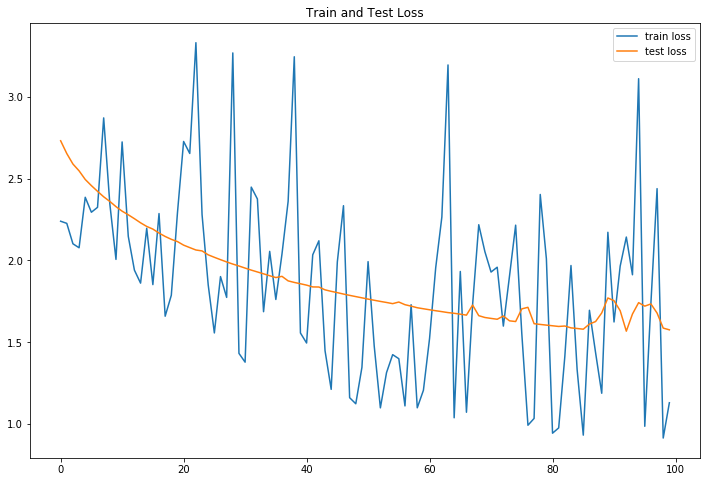

In [62]:
fig = plt.figure(figsize=(12, 8))
plt.plot(train_loss, label='train loss')
plt.plot(test_loss, label='test loss')
plt.title("Train and Test Loss")
plt.legend()
plt.show()

<function matplotlib.pyplot.show(*args, **kw)>

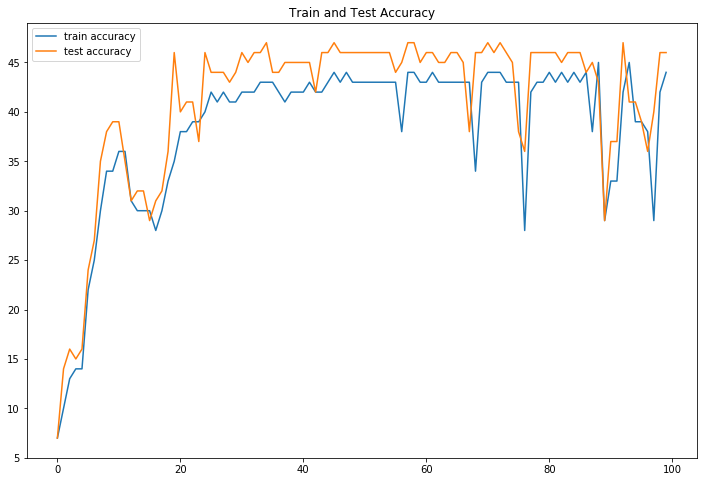

In [63]:
fig = plt.figure(figsize=(12, 8))
plt.plot(train_accuracy, label='train accuracy')
plt.plot(test_accuracy, label='test accuracy')
plt.title("Train and Test Accuracy")
plt.legend()
plt.show

In [64]:
#setting up dataframe for 2nd neural network (synthesis)
def create_move_df(song_id, filename):
    features = sp.audio_features(song_id)
    beats = get_beats(song_id, filename)
    song_features = features[0]
    analysis = sp.audio_analysis(song_id)
    sections = analysis['sections']
    curr_section_num = 0
    curr_section = sections[curr_section_num]

    #can add whatever features we feel like later, these ones felt like the most important for now
    cols = ["start_time", "duration", "section", "tempo", "danceability", "energy", "valence"]
    training_df_of_moves = pd.DataFrame(columns=cols)

    #add data to data frame (start, duration, section, tempo, features)
    for beat in beats[:-1]:
        #sets section number for current beat
        if (curr_section["start"] + curr_section["duration"]) < beat["start"]:
            if curr_section_num + 1 != len(sections):
                curr_section_num = curr_section_num + 1
            curr_section = sections[curr_section_num]
        
        #creating data in row format for df
        beat_data = [beat["start"], beat["duration"], curr_section_num, curr_section["tempo"], song_features["danceability"], song_features["energy"], song_features["valence"]]
        beat_line = pd.DataFrame([beat_data], columns=cols)
        training_df_of_moves = training_df_of_moves.append(beat_line)
    
    return training_df_of_moves

In [65]:
def get_beats(song_id, filename):
    analysis = sp.audio_analysis(song_id)
    #features = sp.audio_features(song_id)
    #Starting beat will change depending on song
    eight_counts = int(re.search("\d+.txt", filename).group()[0])
    beat_count = eight_counts * 8 #not sure if this should be 4 or eight, we will know when we can visualize
    beats = analysis['beats'][beat_count:]
    return beats


In [66]:
#setting up spotify credentials
def set_spotify():
    client_id = 'd0b2731526744c759fcf012a56ec5bd5'
    client_secret = '6e593cabd0e043da9041c5ef5825dec7'

    #Sets up authentication to use the Spotify API
    client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
    #Creates a Spotipy session using the credentials
    sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)
    return sp

sp = set_spotify()
print("Spotify API Reached")

Spotify API Reached


In [67]:
cols = ["start_time", "duration", "section", "tempo", "danceability", "energy", "valence"]
training_df_of_moves = pd.DataFrame(columns=cols)
moves = create_move_df("5N4erncE7kuUccm7zEmwzk", "5N4erncE7kuUccm7zEmwzk_date12_21_Electricity_SilkCity_4.txt")
training_df_of_moves = pd.concat([training_df_of_moves, moves])
training_df_of_moves['index'] = range(0, len(training_df_of_moves))
training_df_of_moves = training_df_of_moves[['index', 'start_time', 'duration', 'section', 'tempo', 'danceability', 'energy', 'valence']]
input_song = training_df_of_moves.to_numpy().tolist()

In [69]:
output = NN(Variable(torch.FloatTensor(input_song)))
_, output_true = torch.max(output.data, 1)

In [70]:
output_true

tensor([ 8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
         8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
         8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
         8,  8,  8,  8,  8,  8,  8,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
         5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
         5,  5,  5,  5,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
         2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
         2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
         2,  2,  2,  2,  2,  2,  2,  2, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11,
        11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
        11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,  4,  4,  4,  4,  4,  4,
         4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
         4,  4,  4,  4,  4,  4,  4,  4, 